In [1]:
# Import packages
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import scipy

# from tqdm import tqdm
import seaborn as sns

# load in bettor objects

from bettor import bettor, run_market, plot_returns, run_market_fixed_el, gen_election

In [2]:
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
from matplotlib.colors import LinearSegmentedColormap

In [16]:
colors = [
    # "#CC99FF",  # lavender purple (existing)
    "#000080",  # navy blue (existing)
    "#339966",  # forest green (existing)
    "#F4A261",  # muted orange
    "#B22222",  # deep ruby red
    # "#6A4C93",  # royal violet
    "#1D3557",  # dark indigo
    "#2A9D8F",  # teal
    "#457B9D",   # steel blue,
    "#FFB347",  # warm amber/orange
    "#E63946"  # deep crimson red
]

# define mpl colourmap
cmap= LinearSegmentedColormap.from_list("power_predictioncmap", colors)

In [5]:
from collections.abc import Iterable

# need a function to flatten irregular list of lists
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

In [6]:
def evaluate_markets(market_record, maxlag=5):
    mp = np.array(market_record['price_history'])
    tp = np.array(market_record['gen_el'])

    # take first differences
    tp_diff = np.diff(tp)
    mp_diff = np.diff(mp)
    ts_data = np.column_stack([mp_diff, tp_diff])

    mse = np.mean((mp-tp)**2)

    res = grangercausalitytests(ts_data, maxlag=maxlag, addconst=True, verbose=False)

    # pull p-values from one of the tests at each lag (e.g., ssr_ftest)
    pvals = {lag: res[lag][0]['ssr_ftest'][1] for lag in res}

    # decide significance at, say, 5%
    sig_lags = [lag for lag, p in pvals.items() if p < 0.05]
    # best_lag = min(sig_lags) if sig_lags else None

    # get lag with lowest p-value
    if pvals:
        best_lag = min(pvals, key=pvals.get)
    else:
        best_lag = None

    return mse, best_lag

In [7]:
# Global parameters

N_bettors = 100
T_max = 100
initial_price = 0.5
rw_variance = 0.05

# number of iterations for each set of parameters
n_iter_ = 30

# Plot 2 - Well informed bettors gain market influence and capital

In [8]:
# set seed
np.random.seed(0)
initial_budget=100

expertise_store = []
budgets = []

# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


expertise_values = np.linspace(0,1,N_bettors)


parameters.update({'bettors': [bettor(expertise=e, budget=initial_budget) for e in expertise_values]})

for _ in range(n_iter_):
    market_record = run_market(**parameters)
    mse, min_sig_lag = evaluate_markets(market_record)
    expertise_store.append([expertise_values])
    budgets.append([x-initial_budget for x in market_record['final_budgets']])


# now with a whale


/opt/homebrew/Caskroom/miniforge/base/envs/power_prediction/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [9]:
# save the expertise_store and budgets_store
import pickle

to_save = {'expertise':list(flatten(expertise_store)), 'budgets':list(flatten(budgets))}

with open('expertise_nowhale.pkl','wb') as f:
    pickle.dump(to_save,f)

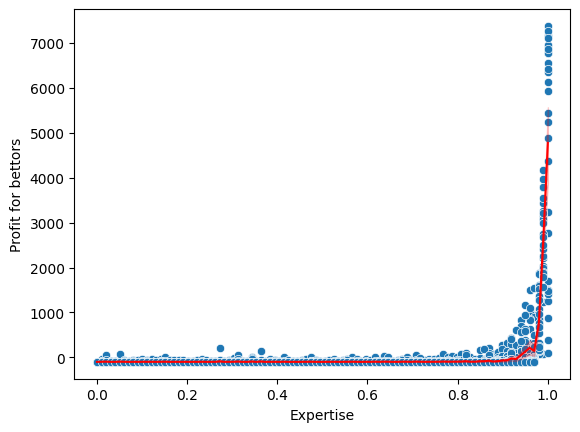

In [10]:
sns.scatterplot(x=list(flatten(expertise_store)),y=list(flatten(budgets)))
sns.lineplot(x=list(flatten(expertise_store)),y=list(flatten(budgets)),c='red')

plt.xlabel('Expertise')
plt.ylabel('Profit for bettors')
plt.savefig('expertise_nowhale.pdf')

# P3 PM is resistant to manipulation by whales

In [11]:
# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': initial_price, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance} # This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability


expertise_values = np.linspace(0,1,N_bettors)

av_budget=100
budget_total = av_budget* N_bettors
N_whales = 1

# expertise_whale = {}

for prop_whale in [0.02,0.05,0.08]:
    
    expertise_store_whale = []
    budgets_whale = []

    whale_budget = av_budget*N_bettors*prop_whale / (1-prop_whale)

    non_whale_bettors = [bettor(budget=av_budget, expertise=expertise_values[i]) for i in range(N_bettors)]
    whale_bettors = [bettor(budget=whale_budget, whale=True, market_valuation=1) for _ in range(N_whales)]

    parameters.update({'bettors': non_whale_bettors + whale_bettors})

    for _ in range(n_iter_):
        market_record = run_market(**parameters)
        expertise_store_whale.append([expertise_values])
        budgets_whale.append([x-av_budget for x in market_record['final_budgets'][:-1]])

    expertise_whale[prop_whale] = [expertise_store_whale, budgets_whale]

KeyboardInterrupt: 

In [ ]:
for k,v in expertise_whale.items():
    budgets_whale = v[1] - np.min(v[1])
    expertise_whale[k].append((np.array(budgets_whale))/ np.max(budgets_whale))

In [ ]:
with open('expertise_whale.pkl','wb') as f:
    pickle.dump(expertise_whale,f)

In [ ]:
props = list(expertise_whale.keys())
props.sort()

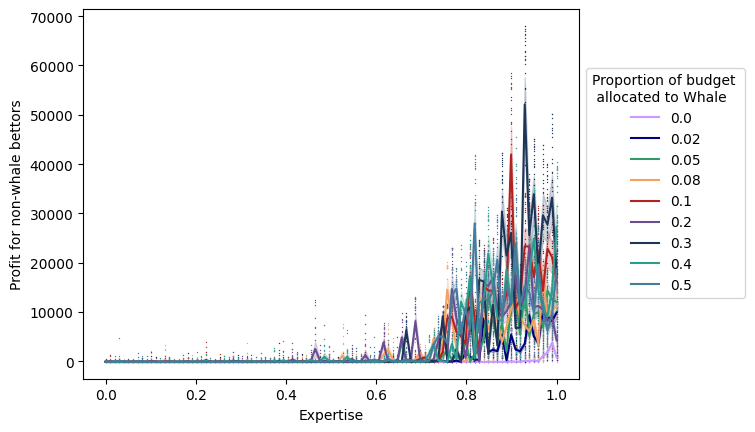

In [ ]:
ind=0
for prop_whale in props:
    expertise_store = expertise_whale[prop_whale][0]
    budgets = expertise_whale[prop_whale][1]
    sns.scatterplot(x=list(flatten(expertise_store)),y=list(flatten(budgets)), s=1,c = colors[ind])
    sns.lineplot(x=list(flatten(expertise_store)),y=list(flatten(budgets)), label=round(prop_whale,2),c = colors[ind])
    ind += 1

plt.xlabel('Expertise')
plt.ylabel('Profit for non-whale bettors')
plt.legend(title = 'Proportion of budget \n allocated to Whale', loc='lower left', bbox_to_anchor=(1,0.2))
plt.savefig('expertise_whale.pdf', bbox_inches='tight')

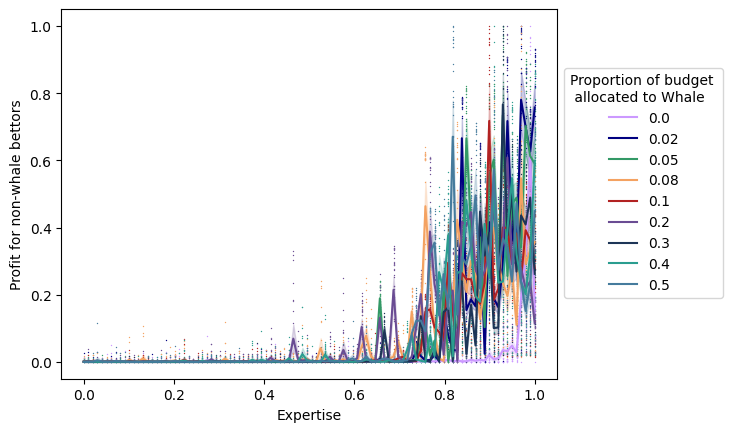

In [ ]:
ind=0
for prop_whale in props:
    expertise_store = expertise_whale[prop_whale][0]
    budgets = expertise_whale[prop_whale][2]
    sns.scatterplot(x=list(flatten(expertise_store)),y=list(flatten(budgets)), s=1,c = colors[ind])
    sns.lineplot(x=list(flatten(expertise_store)),y=list(flatten(budgets)), label=round(prop_whale,2),c = colors[ind])
    ind += 1

plt.xlabel('Expertise')
plt.ylabel('Profit for non-whale bettors')
plt.legend(title = 'Proportion of budget \n allocated to Whale', loc='lower left', bbox_to_anchor=(1,0.2))
plt.savefig('expertise_whale_normalised.pdf', bbox_inches='tight')

In [95]:
# dataframe from dict
import pandas as pd
df_list = []
for k,v in expertise_whale.items():
    df_temp = pd.DataFrame({'expertise':list(flatten(v[0])), 'budgets':list(flatten(v[2])), 'prop_whale':[k for _ in range(len(list(flatten(v[0]))))]})
    df_list.append(df_temp)

# make a single dataframe
df_list = pd.concat(df_list, ignore_index=True)

In [133]:
for g, df_ in df_list.groupby('prop_whale'):
    print(f'Min expertise for a normalised profit above 0.1: {round(g,2)}, {round(np.min(df_[df_.budgets>0.1].expertise),4)}')

    # Compute cumulative budget share
    df_["cum_budget_share"] = df_["budgets"].cumsum() / df_["budgets"].sum()

    print("Expertise threshold for 10% of normalised profit:", round(df_.loc[df_["cum_budget_share"] >= 0.1].expertise.values[0],3))

Min expertise for a normalised profit above 0.1: 0.0, 0.899
Expertise threshold for 10% of normalised profit: 0.0
Min expertise for a normalised profit above 0.1: 0.02, 0.6566
Expertise threshold for 10% of normalised profit: 0.838
Min expertise for a normalised profit above 0.1: 0.05, 0.6566
Expertise threshold for 10% of normalised profit: 0.98
Min expertise for a normalised profit above 0.1: 0.08, 0.1313
Expertise threshold for 10% of normalised profit: 0.808
Min expertise for a normalised profit above 0.1: 0.1, 0.7576
Expertise threshold for 10% of normalised profit: 0.859
Min expertise for a normalised profit above 0.1: 0.2, 0.4141
Expertise threshold for 10% of normalised profit: 0.909
Min expertise for a normalised profit above 0.1: 0.3, 0.6667
Expertise threshold for 10% of normalised profit: 0.667
Min expertise for a normalised profit above 0.1: 0.4, 0.4848
Expertise threshold for 10% of normalised profit: 1.0
Min expertise for a normalised profit above 0.1: 0.5, 0.0303
Expert

In [ ]:
# get the expertise corresponding to the 25th percentile of expertise for the budgets
expertise_25th = df_.expertise[df_.budgets > 0.1].quantile(0.25)

np.float64(247.6916283593149)

In [106]:
# get weighted average expertise by budget for each prop_whale
weighted_expertise = df_list.groupby('prop_whale').apply(lambda x: np.average(x['expertise'], weights=x['budgets'])).reset_index()
weighted_expertise.columns = ['prop_whale', 'weighted_expertise']

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_24983/2062336582.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_expertise = df_list.groupby('prop_whale').apply(lambda x: np.average(x['expertise'], weights=x['budgets'])).reset_index()


<Axes: xlabel='prop_whale', ylabel='weighted_expertise'>

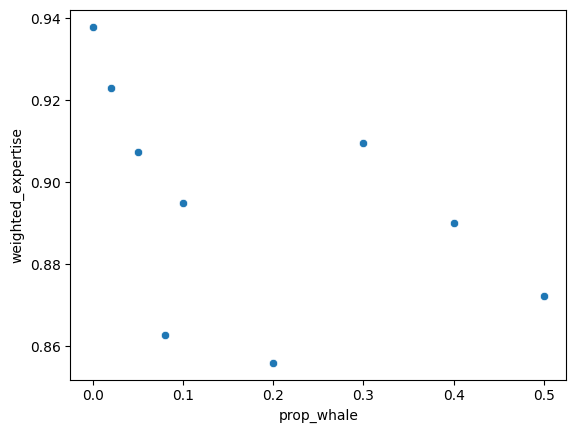

In [109]:
sns.scatterplot(data=weighted_expertise, x='prop_whale', y='weighted_expertise')

ValueError: Could not interpret value `weighted_expertise` for `y`. An entry with this name does not appear in `data`.

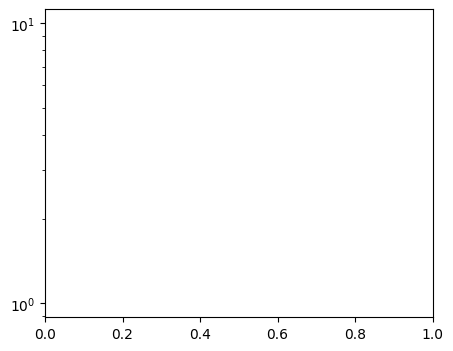

In [ ]:
# set up box plot
plt.figure(figsize=(5,4))
plt.yscale('log')
# make marker size smaller
sns.boxplot(data=df_list[df_list['expertise']<0.5], x='prop_whale', y='budgets', palette = colors, fliersize=1)
plt.xlabel('Proportion of budget allocated to Whale')
plt.ylabel('Normalized profit for non-whale bettors')

# round xtick labels to 1dp
plt.xticks(ticks=np.arange(len(props)), labels=[round(x, 2) for x in props])
plt.ylim(1e-7,10)
plt.savefig('expertise_whale_boxplot.pdf', bbox_inches='tight')

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_24983/4116126654.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_list[df_list['expertise']>=0.5], x='prop_whale', y='budgets', palette = colors, fliersize=1)
/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_24983/4116126654.py:5: UserWarning: The palette list has more values (11) than needed (9), which may not be intended.
  sns.boxplot(data=df_list[df_list['expertise']>=0.5], x='prop_whale', y='budgets', palette = colors, fliersize=1)


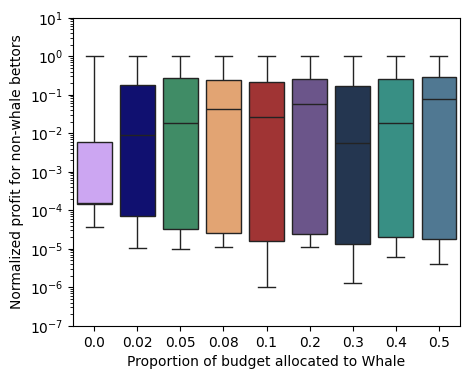

In [103]:
# set up box plot
plt.figure(figsize=(5,4))
plt.yscale('log')
# make marker size smaller
sns.boxplot(data=df_list[df_list['expertise']>=0.5], x='prop_whale', y='budgets', palette = colors, fliersize=1)
plt.xlabel('Proportion of budget allocated to Whale')
plt.ylabel('Normalized profit for non-whale bettors')

# round xtick labels to 1dp
plt.xticks(ticks=np.arange(len(props)), labels=[round(x, 2) for x in props])
plt.ylim(1e-7,10)
plt.savefig('expertise_whale_boxplot.pdf', bbox_inches='tight')

In [136]:
df_list['weighted_expertise'] = df_list.expertise * df_list.budgets

/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_24983/403612874.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_list, x='prop_whale', y='weighted_expertise', palette = colors, fliersize=1)
/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_24983/403612874.py:5: UserWarning: The palette list has more values (11) than needed (9), which may not be intended.
  sns.boxplot(data=df_list, x='prop_whale', y='weighted_expertise', palette = colors, fliersize=1)


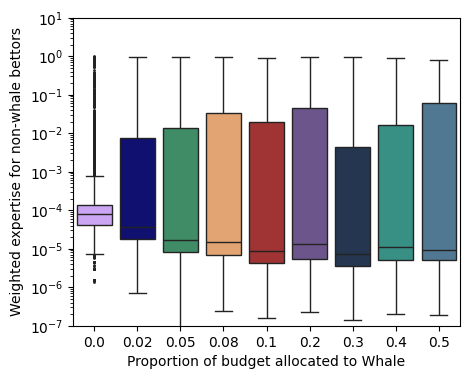

In [142]:
# set up box plot
plt.figure(figsize=(5,4))
plt.yscale('log')
# make marker size smaller
sns.boxplot(data=df_list, x='prop_whale', y='weighted_expertise', palette = colors, fliersize=1)
plt.xlabel('Proportion of budget allocated to Whale')
plt.ylabel('Weighted expertise for non-whale bettors')

# round xtick labels to 1dp
plt.xticks(ticks=np.arange(len(props)), labels=[round(x, 2) for x in props])
plt.ylim(1e-7,10)
plt.savefig('expertise_whale_boxplot.pdf', bbox_inches='tight')

### Market shock

In [8]:
n_iter=100

In [10]:
T_max = 200

In [11]:
# Set initial input values to the betting market function
parameters = {'n_bettors': N_bettors, # The number of betting agents
                #'el_outcome': 1, # Q: Ultimate election outcome - assuming we know this to begin with and it does not change over time...for now this is implemented as a random walk of the probability...but should this be 0 or 1 instead? '''
            't_election': T_max, # Time until election takes place (ie. time horizon of betting)
            'initial_price': 0.4, # Initial market price (is this equivalent to probability of winning)
            'outcome_uncertainty': rw_variance,# This is a measure of how uncertain the true outcome is - ie. the volatility of the random walk election probability
            'market_lambda': 1/50} # market step size parameter


# expertise_values = np.linspace(0,1,N_bettors)

av_budget=100
budget_total = av_budget* N_bettors
N_whales = 1
whale_valuation = 0.7

expertise_whale = {}

for prop_whale in [0,0.01,0.1,0.5,0.7]:
    
    whale_effect = []

    whale_budget = av_budget*N_bettors*prop_whale / (1-prop_whale)

    non_whale_bettors = [bettor(budget=av_budget, expertise=0.95, risk_av=1, stubbornness=0) for i in range(N_bettors)]
    whale_bettors = [bettor(budget=whale_budget, whale=True, market_valuation=whale_valuation,risk_av=1, stubbornness=0) for _ in range(N_whales)]

    print(f'Running for prop_whale={prop_whale}, whale_budget={whale_budget} and total non-whale budget={av_budget*N_bettors}')
    parameters.update({'bettors': non_whale_bettors + whale_bettors})

    for _ in range(n_iter_):
        market_record = run_market(**parameters)

        whale_effect.append((np.array(market_record['price_history']) -  np.array(market_record['gen_el'])))

    expertise_whale[prop_whale] = whale_effect

Running for prop_whale=0, whale_budget=0.0 and total non-whale budget=10000


/Users/bridgetsmart/Documents/GitHub/power_prediction/code/simulations/bettor.py:49: RuntimeWarning: divide by zero encountered in log
  return np.log(w)


Running for prop_whale=0.01, whale_budget=101.01010101010101 and total non-whale budget=10000
Running for prop_whale=0.1, whale_budget=1111.111111111111 and total non-whale budget=10000
Running for prop_whale=0.5, whale_budget=10000.0 and total non-whale budget=10000
Running for prop_whale=0.7, whale_budget=23333.33333333333 and total non-whale budget=10000


In [12]:
times = np.arange(T_max+1)
vals = []
for k,val in expertise_whale.items():
    for v in val:
        for x in range(T_max+1):
            vals.append([k,v[x],times[x]])


df_plot = pd.DataFrame(vals, columns = ['PropWhale','SE','T'])

In [1]:

sns.lineplot(data = df_plot, x='T', y='SE',hue='PropWhale', palette=cmap)
plt.xlabel('Time since shock')
plt.legend(title = 'Proportion of budget \n allocated to Whale', loc='lower left', bbox_to_anchor=(1,0.2))
plt.ylabel('Absolute difference between market price and \n true election outcome')
# round labels in legend to 1dp
# get current legend
legend = plt.gca().get_legend()
for text in legend.get_texts():
    text.set_text(f"{float(text.get_text()):.2f}")
plt.savefig('ShockDuration.pdf', bbox_inches='tight')

NameError: name 'sns' is not defined